In [64]:
%pip install cvxopt

import yfinance as yf
import numpy as np
import pandas as pd
import pandas_ta as ta
import cvxopt


Note: you may need to restart the kernel to use updated packages.


In [65]:
def fetch_data(ticker='SPY', start='2015-01-01', end='2023-12-31'):
    data = yf.download(ticker, start, end)
    data = data[['Close']]
    data.dropna(inplace=True)
    return data

def simple_moving_average(data, window=15):
    df = data.copy()
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()
    return df

def exponential_moving_average(data, span=20):
    df = data.copy()
    df[f'EMA_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()
    return df


def relative_strength_index_ema(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.ewm(window,adjust=False).mean()
    avg_loss = down.ewm(window,adjust=False).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_ema'] = 100 - (100 / (1 + rs))
    return df

def relative_strength_index_sma(data,window=14):
    df = data.copy()
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down =  delta.clip(upper=0).abs()
    avg_gain = up.rolling(window=window).mean()
    avg_loss = down.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    df[f'RSI_{window}_sma'] = 100 - (100 / (1 + rs))
    return df


def bollinger_bands(data):
    df = data.copy()
    sma = df['Close'].rolling(window=20).mean()
    std = df['Close'].rolling(window=20).std()
    df['Bollinger_Upper'] = sma + 2 * std
    df['Bollinger_Lower'] = sma - 2 * std
    return df

def macd_ewm(data):
    df = data.copy()
    ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df


def daily_return(data):
    df= data.copy()
    df['Daily_Return'] = df['Close'].pct_change()
    return df

def rolling_volatility(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Rolling_5d_Std'] = df['Daily_Return'].rolling(window=5).std()
    return df

def lagged_returns(data):
    df = data.copy()
    #df['Daily_Return'] = df['Close'].pct_change()
    df['Lag_1'] = df['Daily_Return'].shift(1)
    df['Lag_2'] = df['Daily_Return'].shift(2)
    df['Lag_3'] = df['Daily_Return'].shift(3)
    return df

def compute_technical_indicators(data):
    df = data.copy()
    # Momentum
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)
    return df

In [66]:
data = fetch_data('SPY', '2015-01-01', '2025-07-05')
data = simple_moving_average(data, window=15)
data = exponential_moving_average(data, span=20)
data = relative_strength_index_ema(data, window=14)
data = relative_strength_index_sma(data, window=14)
data = bollinger_bands(data)
data = macd_ewm(data)
data = daily_return(data)
data = rolling_volatility(data)
data = lagged_returns(data)
data = compute_technical_indicators(data)



C:\Users\Micha\AppData\Local\Temp\ipykernel_39100\24724489.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


In [67]:
data['Daily_Return_Sign'] = np.where(data['Daily_Return'].shift(-1) > 0, 1, -1)
data = data.dropna()
data = data.drop(columns=['Close','Daily_Return'])  
data


Price,SMA_15,EMA_20,RSI_14_ema,RSI_14_sma,Bollinger_Upper,Bollinger_Lower,MACD,MACD_Signal,Rolling_5d_Std,Lag_1,Lag_2,Lag_3,Momentum_10,Daily_Return_Sign
Ticker,,,,,,,,,,,,,,
Date,,,,,,,,,,,,,,
2015-01-30,169.063652,169.370531,23.546695,39.839249,172.828022,165.551791,-0.636610,-0.474047,0.010508,0.009243,-0.012825,-0.013191,0.359146,1
2015-02-02,168.933924,169.300632,28.787166,48.509682,172.510219,165.576452,-0.616099,-0.502457,0.013018,-0.012575,0.009243,-0.012825,0.242157,1
2015-02-03,169.055862,169.469648,34.476110,55.141711,172.744020,165.603221,-0.398467,-0.481659,0.013672,0.012384,-0.012575,0.009243,2.321762,-1
2015-02-04,169.166109,169.560528,33.705501,56.060713,172.791613,165.909734,-0.275382,-0.440404,0.011650,0.014461,0.012384,-0.012575,0.818466,1
2015-02-05,169.458974,169.806601,37.649116,63.335852,173.162817,165.856724,-0.038570,-0.360037,0.011753,-0.003808,0.014461,0.012384,0.016678,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,601.389893,598.693038,69.373928,68.391896,612.911016,585.016236,7.985536,7.483408,0.004208,0.007824,0.000560,0.011047,12.939575,1
2025-06-30,602.754956,600.517509,70.938956,69.907840,615.740797,585.206175,8.552787,7.697283,0.003899,0.004968,0.007824,0.000560,22.609680,-1


In [68]:
# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
    print(f"{repo_root} added to sys.path.")
else:
    print("Repo root already in sys.path.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Repo root already in sys.path.


In [69]:
from courselib.utils.splits import train_test_split
from courselib.utils.normalization import standardize
training_data_fraction = .8
X, Y, X_train, Y_train, X_test, Y_test = train_test_split(data, training_data_fraction=0.8, class_column_name='Daily_Return_Sign', return_numpy=True)
X = standardize(X)
X_test = standardize(X_test)
X_train = standardize(X_train)


In [70]:
from courselib.models.svm import LinearSVM
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import binary_accuracy

w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true), 
                "loss": lambda y_pred, y_true: np.mean(np.maximum(0, 1 - y_true * y_pred))}

svm = LinearSVM(w, b, optimizer, C=10.)
metrics_history = svm.fit(X_train,Y_train, num_epochs = 50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)

In [71]:
svm.w, svm.b

(array([ 2.62788828e-03,  2.26394527e-03, -5.41089834e-03,  4.52332871e-03,
         2.28998904e-03, -4.99586754e-04, -3.72996803e-04,  4.39686610e-04,
        -1.82418753e-03,  1.83178216e-03,  5.34423087e-04, -9.67479386e-04,
        -1.28162166e-03,  1.02623233e+00]),
 array(0.10230546))

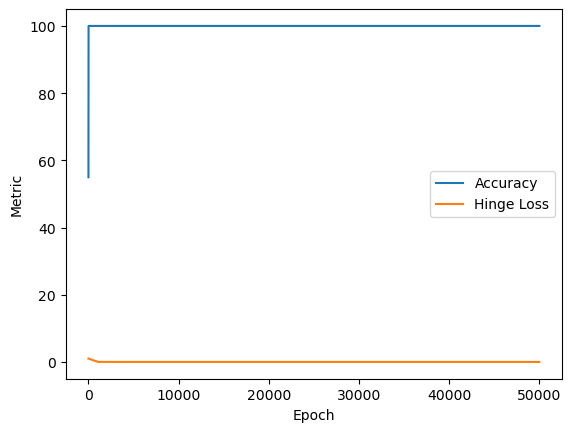

In [72]:
import matplotlib.pyplot as plt

plt.plot(metrics_history["accuracy"], label="Accuracy")
plt.plot(metrics_history["loss"], label="Hinge Loss")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.show()


In [73]:
y_pred_test = svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)

Test Accuracy: 100.0


In [74]:
from courselib.models.glm import LogisticRegression
w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-4)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true), 
                "loss": lambda y_pred, y_true: np.mean(np.maximum(0, 1 - y_true * y_pred))}
logistic_regression = LogisticRegression(w, b, optimizer)
metrics_history = logistic_regression.fit(X_train, Y_train, num_epochs=50000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)
logistic_regression.w, logistic_regression.b

(array([ 3.38666582e-02,  3.45159911e-02,  2.02443347e-03, -1.21509404e-02,
         3.22170320e-02,  3.68158449e-02, -4.18929583e-03, -1.08462250e-02,
        -5.71234037e-02,  6.22872731e-02,  9.60722580e-03, -7.22389480e-02,
         3.50417831e-02,  3.50645263e+00]),
 array(-1.67191191))

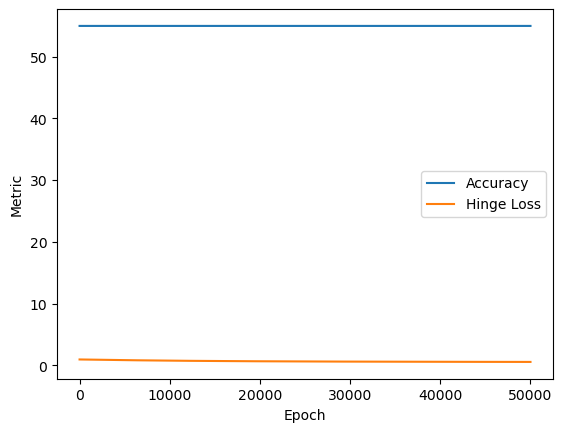

In [75]:
plt.plot(metrics_history["accuracy"], label="Accuracy")
plt.plot(metrics_history["loss"], label="Hinge Loss")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()
plt.show()

In [76]:
y_pred_test = svm(X_test)
test_acc = binary_accuracy(y_pred_test, Y_test)
print("Test Accuracy:", test_acc)

Test Accuracy: 100.0
